# Experiment 2: Inference - CIFAR-10 Text-to-Image with CFG

This notebook loads the trained CIFAR-10 text-to-image model and explores its generation capabilities.

**Purpose:**
- Load trained model from checkpoint
- Test generation with different prompts and guidance scales
- Visualize real vs generated images
- Explore failure cases and edge cases

**Prerequisites:**
- Complete training using `train1_t2i_cifar10_cfg.ipynb`

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_2_CONFIG,
    INFERENCE_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    CIFAR10_CLASSES,
    DATASET_CACHE_DIR,
    get_latest_cifar10_unet_checkpoint,
)

# Deep learning frameworks
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# Print configuration
print("CIFAR-10 Classes:")
for i, c in enumerate(CIFAR10_CLASSES):
    print(f"  {i}: {c}")

print(f"\nPrompt template: '{EXPERIMENT_2_CONFIG['prompt_template']}'")
print(f"Inference steps: {INFERENCE_CONFIG['num_inference_steps']}")

CIFAR-10 Classes:
  0: airplane
  1: automobile
  2: bird
  3: cat
  4: deer
  5: dog
  6: frog
  7: horse
  8: ship
  9: truck

Prompt template: 'A photo of a {class_name}'
Inference steps: 50


## 2. Load Models

In [4]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe


In [5]:
# Load trained UNet from latest checkpoint
from models.custom_unet_cifar10 import load_cifar10_unet_from_latest_checkpoint

unet, checkpoint = load_cifar10_unet_from_latest_checkpoint(device=device)
unet.eval()

print(f"✓ Loaded CIFAR-10 UNet model")
print(f"  Parameters: {unet.get_num_parameters():,}")

Loading checkpoint: /home/doshlom4/work/final_project/checkpoints/cifar10_unet_checkpoint_epoch_50.pt
Loaded model from epoch 50
✓ Loaded CIFAR-10 UNet model
  Parameters: 35,499,523


In [8]:
# Load CLIP text encoder and tokenizer
import os
os.environ['HF_HOME'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface")
os.environ['HF_DATASETS_CACHE'] = str(PROJECT_ROOT / "dataset_cache")

print(f"CLIP_MODEL_NAME: {CLIP_MODEL_NAME}")
print(f"Cache directory: {os.environ['HF_HOME']}")

# Check if model is cached
from pathlib import Path
model_cache_path = Path(os.environ['HF_HOME']) / "hub" / f"models--{CLIP_MODEL_NAME.replace('/', '--')}"
if model_cache_path.exists():
    print(f"✓ Model already cached at: {model_cache_path}")
    print(f"Cache size: {sum(f.stat().st_size for f in model_cache_path.rglob('*') if f.is_file()) / 1024**3:.2f} GB")
else:
    print("⚠ Model not cached - will download now (this may take several minutes)")

# Load with explicit cache directory
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME, cache_dir=os.environ['HF_HOME']).to(device)
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME, cache_dir=os.environ['HF_HOME'])

text_encoder.eval()

print(f"✓ Loaded CLIP text encoder: {CLIP_MODEL_NAME}")

CLIP_MODEL_NAME: openai/clip-vit-base-patch32
Cache directory: /home/doshlom4/work/final_project/dataset_cache/huggingface
⚠ Model not cached - will download now (this may take several minutes)
✓ Loaded CLIP text encoder: openai/clip-vit-base-patch32


In [9]:
# Create noise scheduler for inference
scheduler = DDPMScheduler(
    beta_schedule=INFERENCE_CONFIG["beta_schedule"],
    num_train_timesteps=INFERENCE_CONFIG["num_train_timesteps"]
)

print(f"✓ Created DDPM scheduler")

✓ Created DDPM scheduler


## 3. Generation Functions

In [10]:
@torch.no_grad()
def generate_images(
    prompt: str,
    guidance_scale: float = 5.0,
    num_images: int = 1,
    num_inference_steps: int = None,
    show_progress: bool = True
) -> torch.Tensor:
    """
    Generate CIFAR-10 images using classifier-free guidance.
    
    Args:
        prompt: Text prompt (e.g., "A photo of a cat")
        guidance_scale: CFG scale (higher = more prompt adherence)
        num_images: Number of images to generate
        num_inference_steps: Override default inference steps
        show_progress: Whether to show progress bar
        
    Returns:
        Tensor of shape (num_images, 3, 32, 32) in [0, 1] range
    """
    if num_inference_steps is None:
        num_inference_steps = INFERENCE_CONFIG["num_inference_steps"]
    
    # Encode text prompt
    text_input = tokenizer(
        [prompt] * num_images,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # Unconditional embeddings (empty prompt)
    uncond_input = tokenizer(
        [""] * num_images,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    
    # Concatenate for CFG
    embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize random noise
    latents = torch.randn((num_images, 3, 32, 32), device=device)
    
    # Setup scheduler
    scheduler.set_timesteps(num_inference_steps)
    
    # Denoising loop
    timesteps = tqdm(scheduler.timesteps, desc="Generating") if show_progress else scheduler.timesteps
    for t in timesteps:
        # Duplicate latents for CFG
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        # Predict noise
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample
        
        # Apply CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # Denoising step
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Denormalize from [-1, 1] to [0, 1]
    images = (latents / 2 + 0.5).clamp(0, 1)
    
    return images

print("Generation function defined")

Generation function defined


In [11]:
def display_images(images, title=None):
    """
    Display a batch of images.
    """
    n = len(images)
    cols = min(n, 8)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 2.5 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        if i < n:
            img = images[i].permute(1, 2, 0).cpu().numpy()
            ax.imshow(img)
        ax.axis('off')
    
    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("Display function defined")

Display function defined


## 4. Test Generation - All Classes

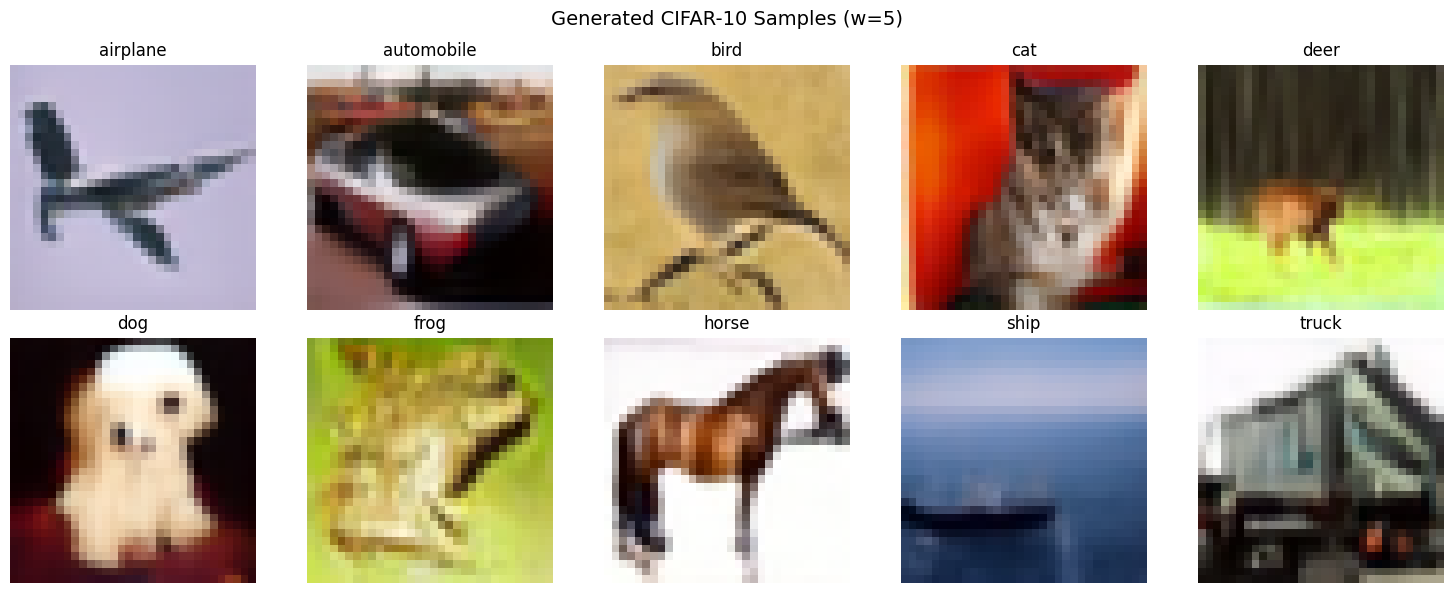

In [12]:
# Generate one image per class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, class_name in enumerate(CIFAR10_CLASSES):
    prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
    image = generate_images(prompt, guidance_scale=5.0, num_images=1, show_progress=False)
    
    ax = axes[i // 5, i % 5]
    ax.imshow(image[0].permute(1, 2, 0).cpu().numpy())
    ax.set_title(class_name)
    ax.axis('off')

plt.suptitle('Generated CIFAR-10 Samples (w=5)', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Compare Real vs Generated

In [11]:
# Load real CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10_test = CIFAR10(
    root=str(DATASET_CACHE_DIR),
    train=False,
    download=True,
    transform=transform
)

print(f"Loaded CIFAR-10 test set: {len(cifar10_test)} images")

Loaded CIFAR-10 test set: 10000 images


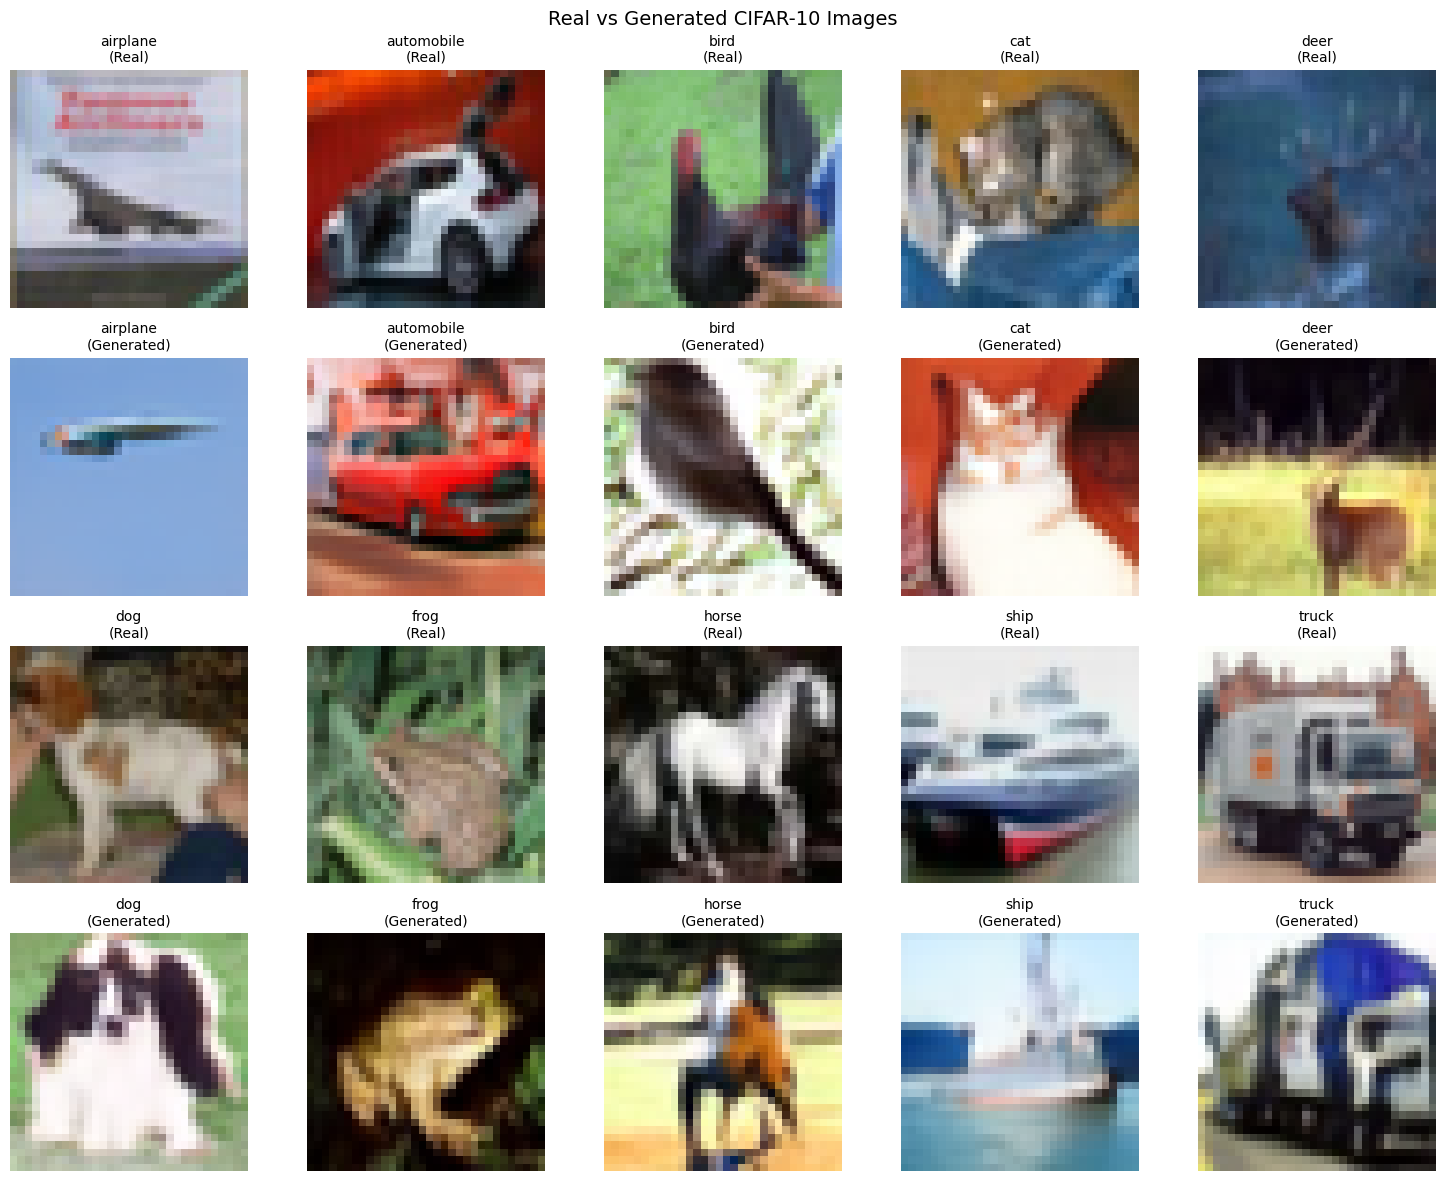

In [12]:
# Compare real vs generated for each class
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Get indices for each class in test set
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(cifar10_test):
    class_indices[label].append(idx)

for i, class_name in enumerate(CIFAR10_CLASSES):
    row = (i // 5) * 2
    col = i % 5
    
    # Real image
    real_idx = class_indices[i][0]
    real_img, _ = cifar10_test[real_idx]
    axes[row, col].imshow(real_img.permute(1, 2, 0).numpy())
    axes[row, col].set_title(f"{class_name}\n(Real)", fontsize=10)
    axes[row, col].axis('off')
    
    # Generated image
    prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
    gen_img = generate_images(prompt, guidance_scale=5.0, num_images=1, show_progress=False)
    axes[row + 1, col].imshow(gen_img[0].permute(1, 2, 0).cpu().numpy())
    axes[row + 1, col].set_title(f"{class_name}\n(Generated)", fontsize=10)
    axes[row + 1, col].axis('off')

plt.suptitle('Real vs Generated CIFAR-10 Images', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Effect of Guidance Scale

A photo of a airplane


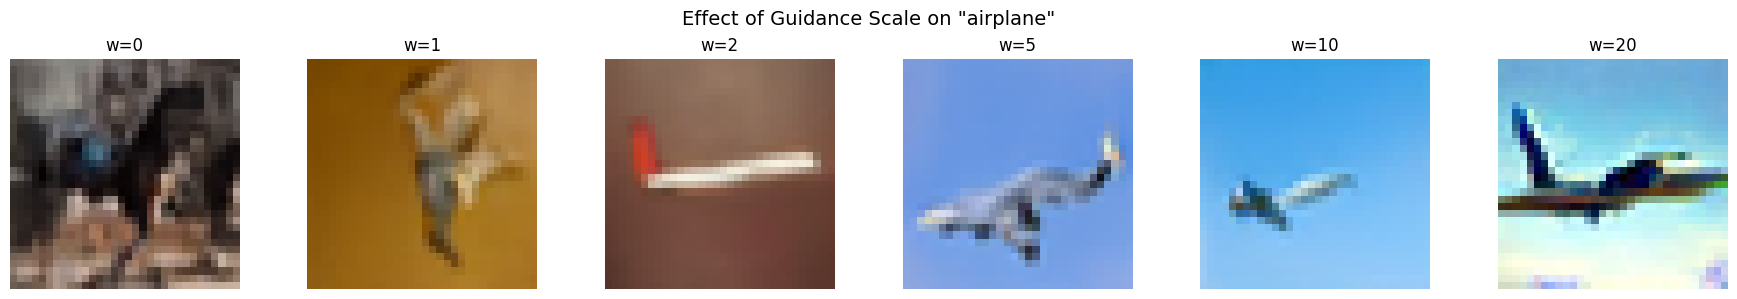

In [13]:
# Test different guidance scales for one class
test_class = "airplane"
guidance_scales = [0, 1, 2, 5, 10, 20]

fig, axes = plt.subplots(1, len(guidance_scales), figsize=(18, 3))

prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=test_class)
print(prompt)

for i, w in enumerate(guidance_scales):
    image = generate_images(prompt, guidance_scale=w, num_images=1, show_progress=False)
    axes[i].imshow(image[0].permute(1, 2, 0).cpu().numpy())
    axes[i].set_title(f'w={w}')
    axes[i].axis('off')

plt.suptitle(f'Effect of Guidance Scale on "{test_class}"', fontsize=14)
plt.tight_layout()
plt.show()

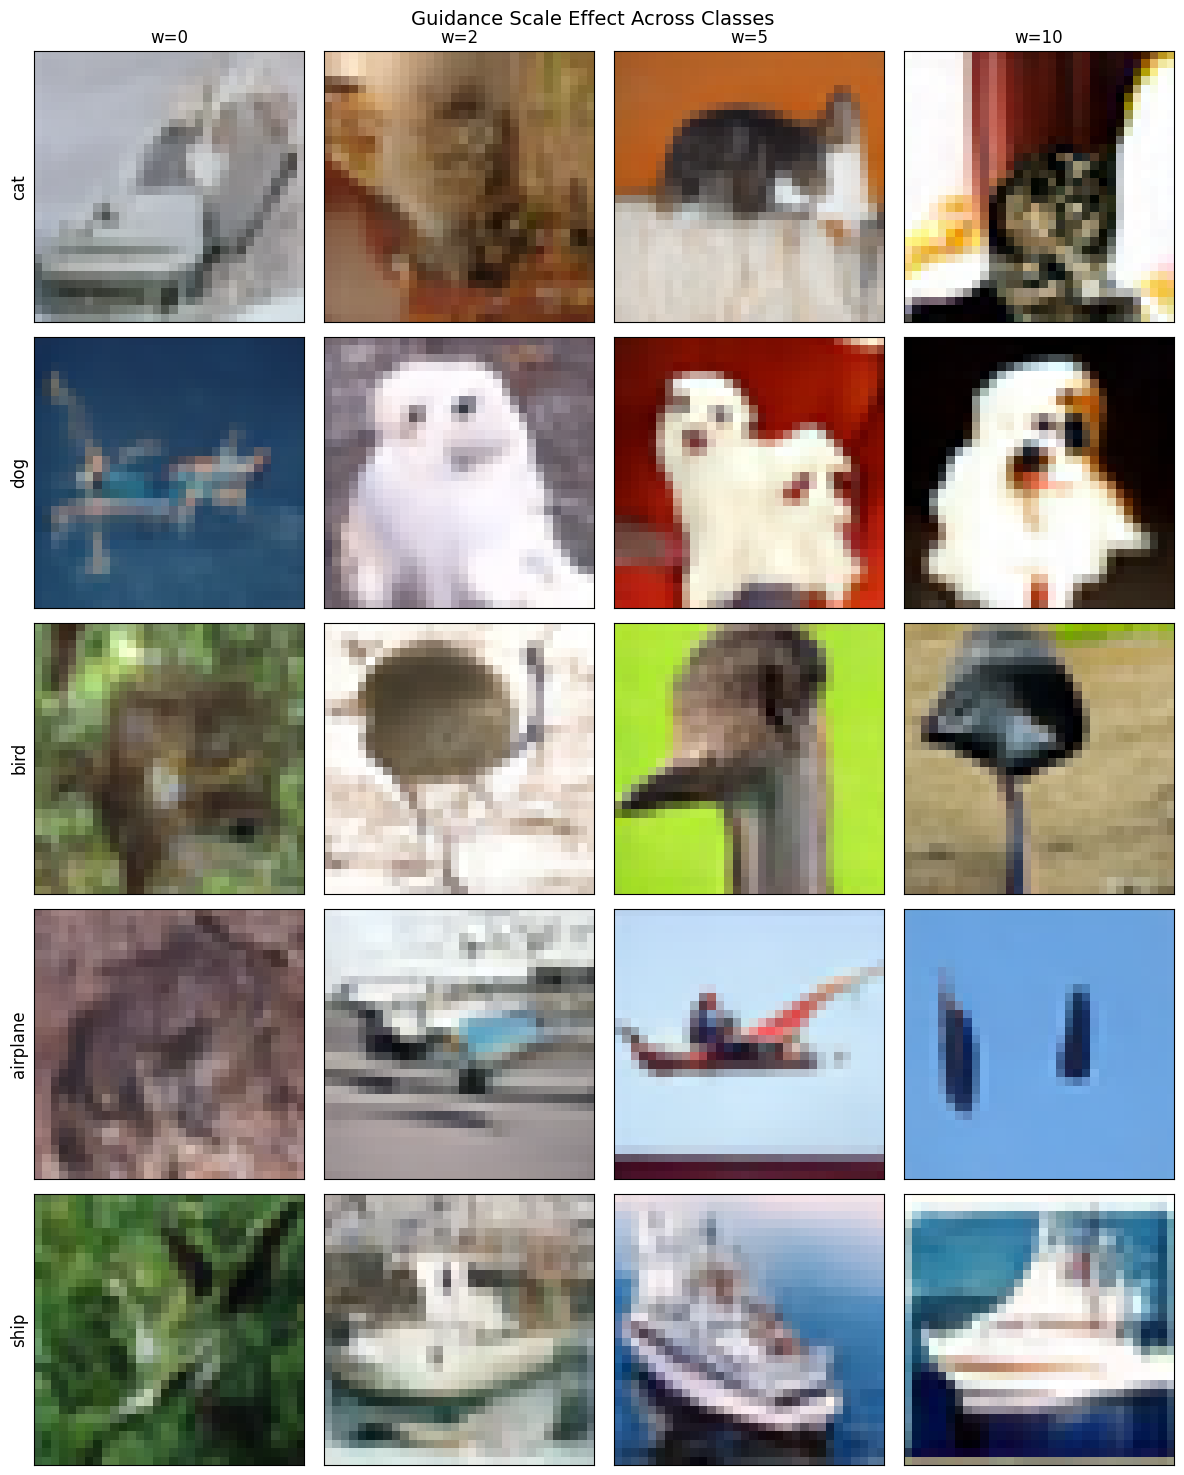

In [14]:
# Compare guidance scales across multiple classes
test_classes = ["cat", "dog", "bird", "airplane", "ship"]
guidance_scales = [0, 2, 5, 10]

fig, axes = plt.subplots(len(test_classes), len(guidance_scales), figsize=(12, 15))

for i, class_name in enumerate(test_classes):
    prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
    
    for j, w in enumerate(guidance_scales):
        image = generate_images(prompt, guidance_scale=w, num_images=1, show_progress=False)
        axes[i, j].imshow(image[0].permute(1, 2, 0).cpu().numpy())
        if i == 0:
            axes[i, j].set_title(f'w={w}')
        if j == 0:
            axes[i, j].set_ylabel(class_name, fontsize=12)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.suptitle('Guidance Scale Effect Across Classes', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Multiple Samples Per Class

Generating: 100%|██████████| 50/50 [00:01<00:00, 38.40it/s]


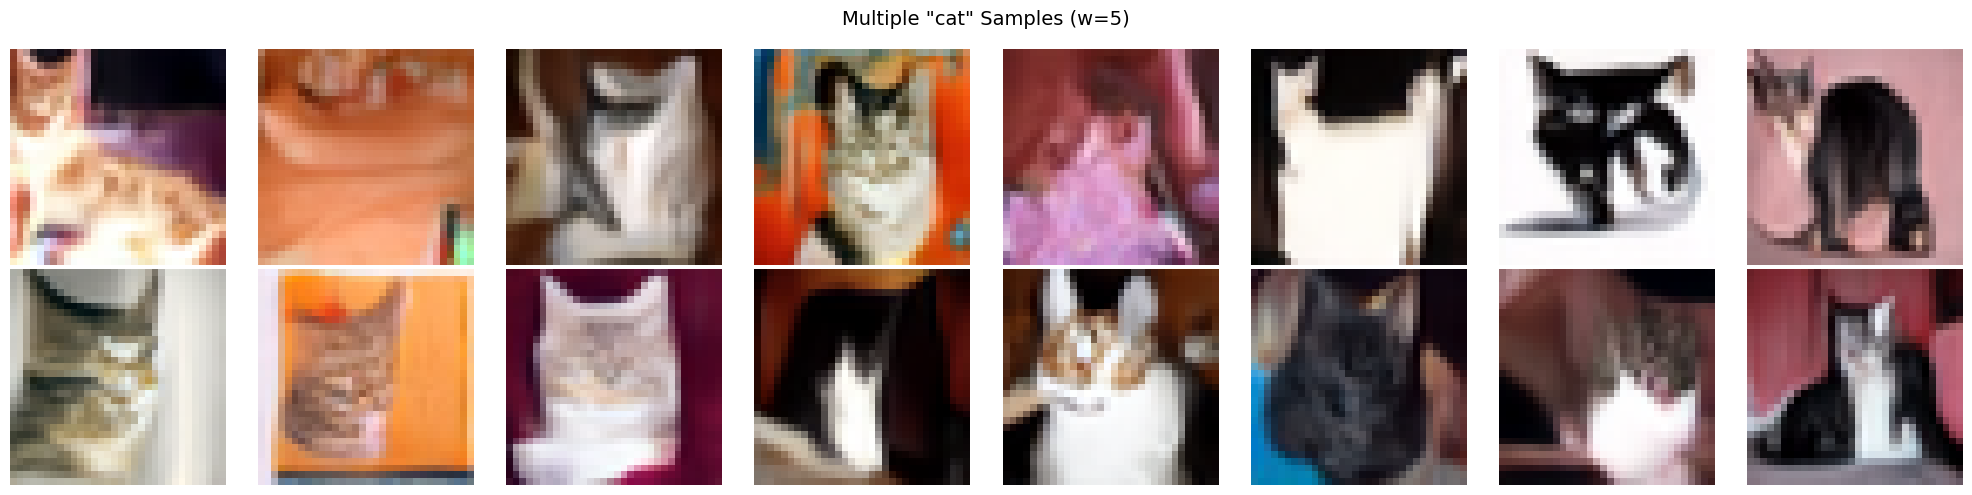

In [15]:
# Generate multiple samples for one class to show diversity
test_class = "cat"
num_samples = 16

prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=test_class)
images = generate_images(prompt, guidance_scale=5.0, num_images=num_samples)

display_images(images, title=f'Multiple "{test_class}" Samples (w=5)')

## 8. Inference Steps Ablation

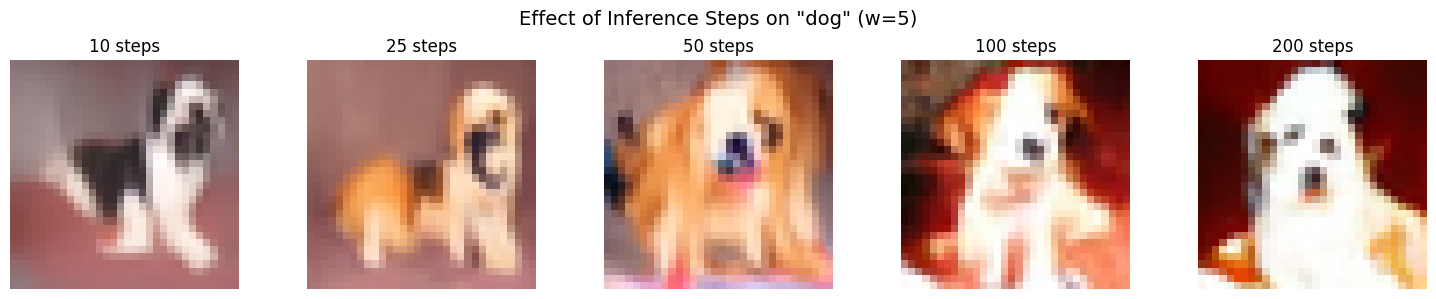

In [16]:
# Compare different number of inference steps
test_class = "dog"
step_counts = [10, 25, 50, 100, 200]

fig, axes = plt.subplots(1, len(step_counts), figsize=(15, 3))

prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=test_class)

# Use same random seed for fair comparison
torch.manual_seed(42)

for i, steps in enumerate(step_counts):
    torch.manual_seed(42)  # Reset seed for each
    image = generate_images(prompt, guidance_scale=5.0, num_images=1, num_inference_steps=steps, show_progress=False)
    axes[i].imshow(image[0].permute(1, 2, 0).cpu().numpy())
    axes[i].set_title(f'{steps} steps')
    axes[i].axis('off')

plt.suptitle(f'Effect of Inference Steps on "{test_class}" (w=5)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Test Custom Prompts

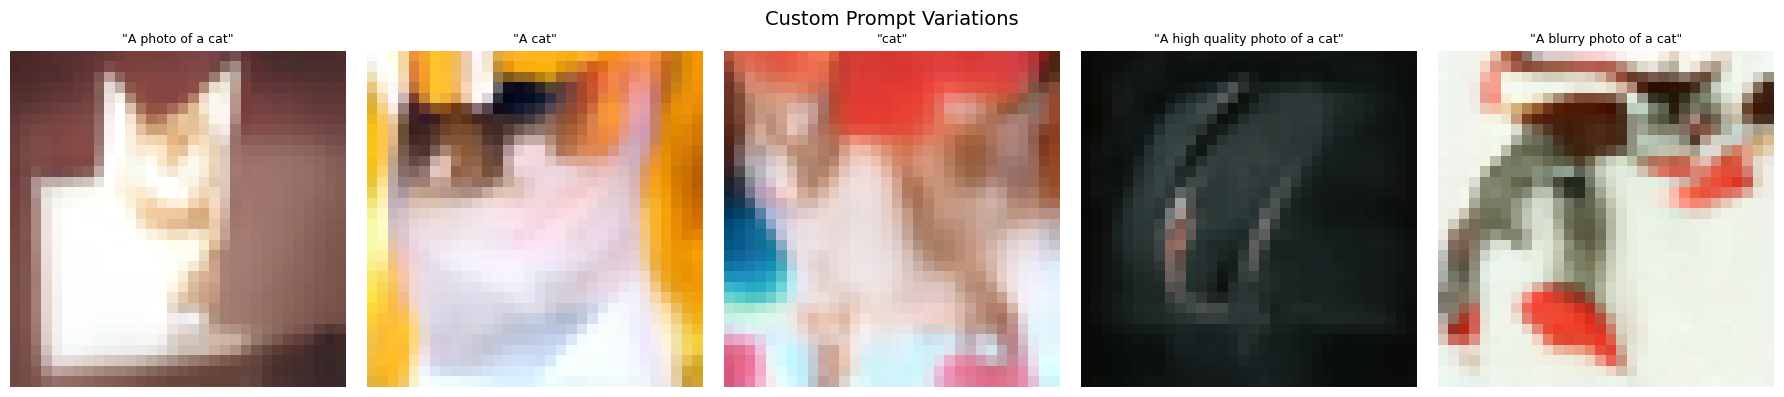

In [17]:
# Test with variations of the prompt template
custom_prompts = [
    "A photo of a cat",
    "A cat",
    "cat",
    "A high quality photo of a cat",
    "A blurry photo of a cat",
]

fig, axes = plt.subplots(1, len(custom_prompts), figsize=(18, 4))

for i, prompt in enumerate(custom_prompts):
    image = generate_images(prompt, guidance_scale=5.0, num_images=1, show_progress=False)
    axes[i].imshow(image[0].permute(1, 2, 0).cpu().numpy())
    axes[i].set_title(f'"{prompt}"', fontsize=9, wrap=True)
    axes[i].axis('off')

plt.suptitle('Custom Prompt Variations', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Generate Multiple Samples Per Class

Generating: 100%|██████████| 50/50 [00:01<00:00, 39.93it/s]


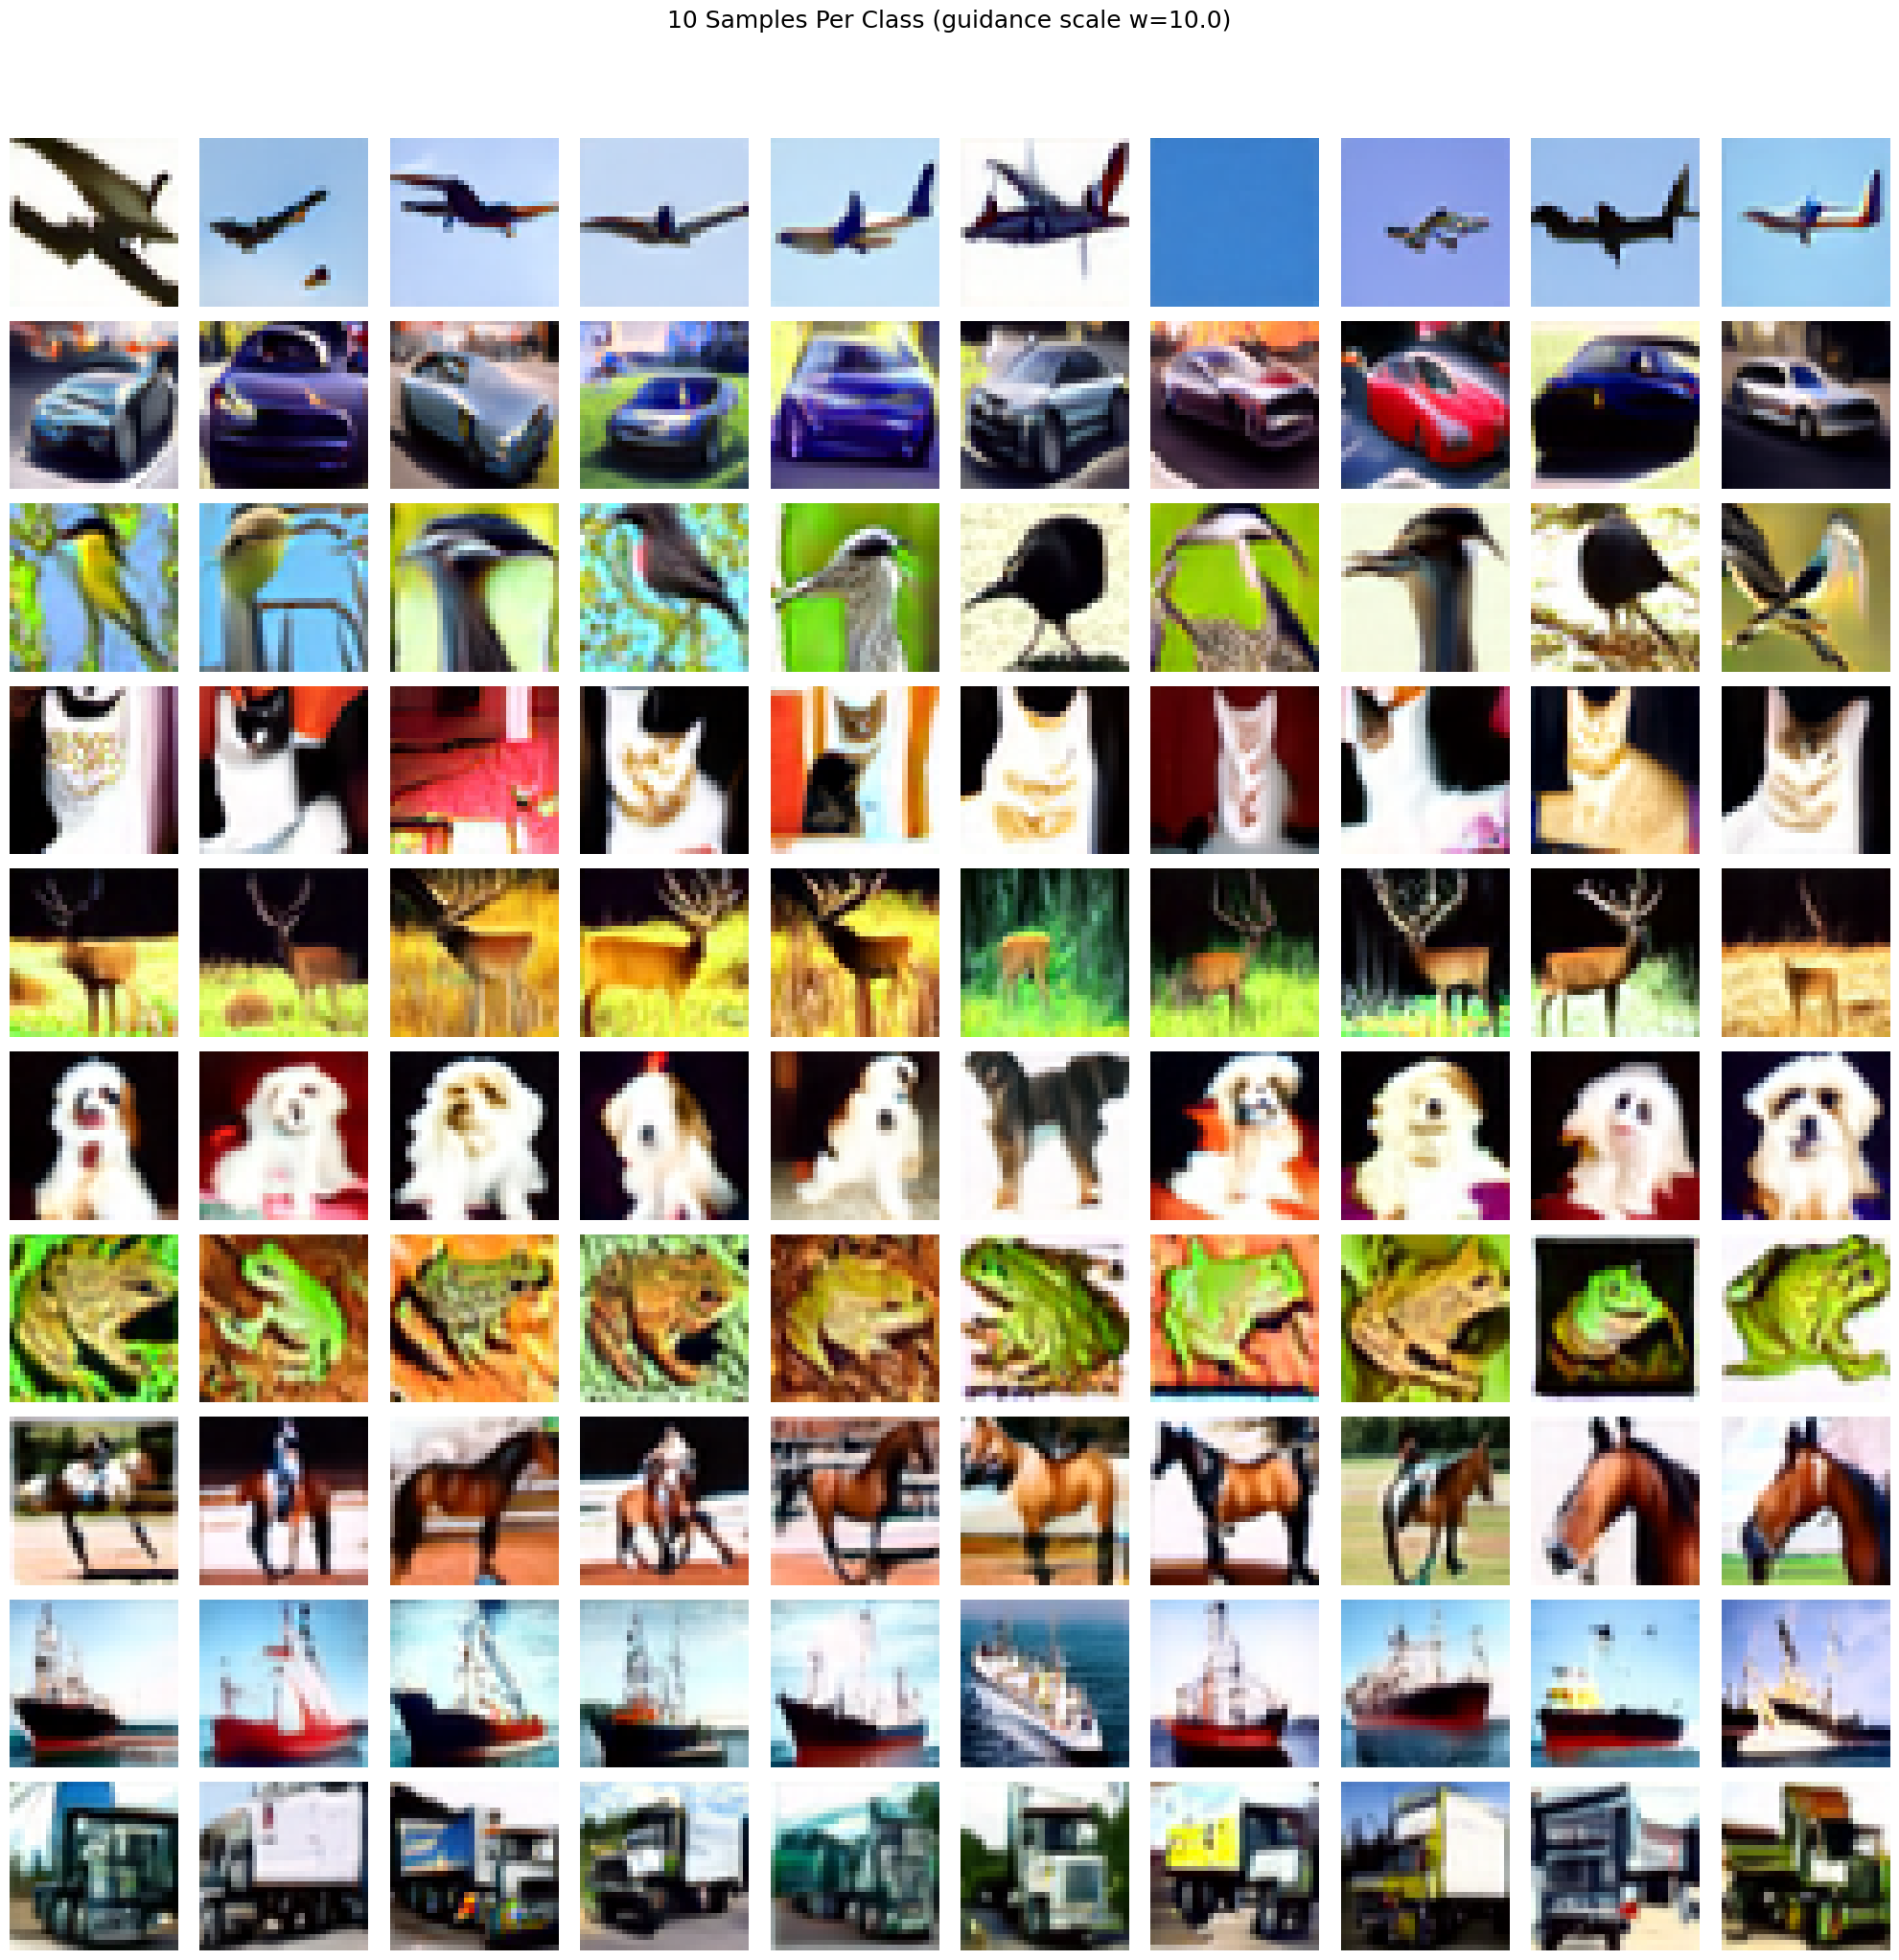

In [14]:
# Generate 10 samples per class (10 classes x 10 samples = 100 images)
num_samples_per_class = 10
guidance_scale = 10.0  # Use higher guidance for better class adherence

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
plt.suptitle(f'10 Samples Per Class (guidance scale w={guidance_scale})', fontsize=18, y=1.02)

for class_idx, class_name in enumerate(CIFAR10_CLASSES):
    prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
    
    # Generate 10 images for this class
    images = generate_images(
        prompt, 
        guidance_scale=guidance_scale, 
        num_images=num_samples_per_class,
        show_progress=True
    )
    
    # Plot each image in the row
    for sample_idx in range(num_samples_per_class):
        ax = axes[class_idx, sample_idx]
        ax.imshow(images[sample_idx].permute(1, 2, 0).cpu().numpy())
        
        # Add class label on the first column
        if sample_idx == 0:
            ax.set_ylabel(class_name, fontsize=12, rotation=0, ha='right', va='center')
        
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## 11. Multiple Samples Per Class Across Guidance Scales

Generating: 100%|██████████| 50/50 [00:01<00:00, 39.48it/s]


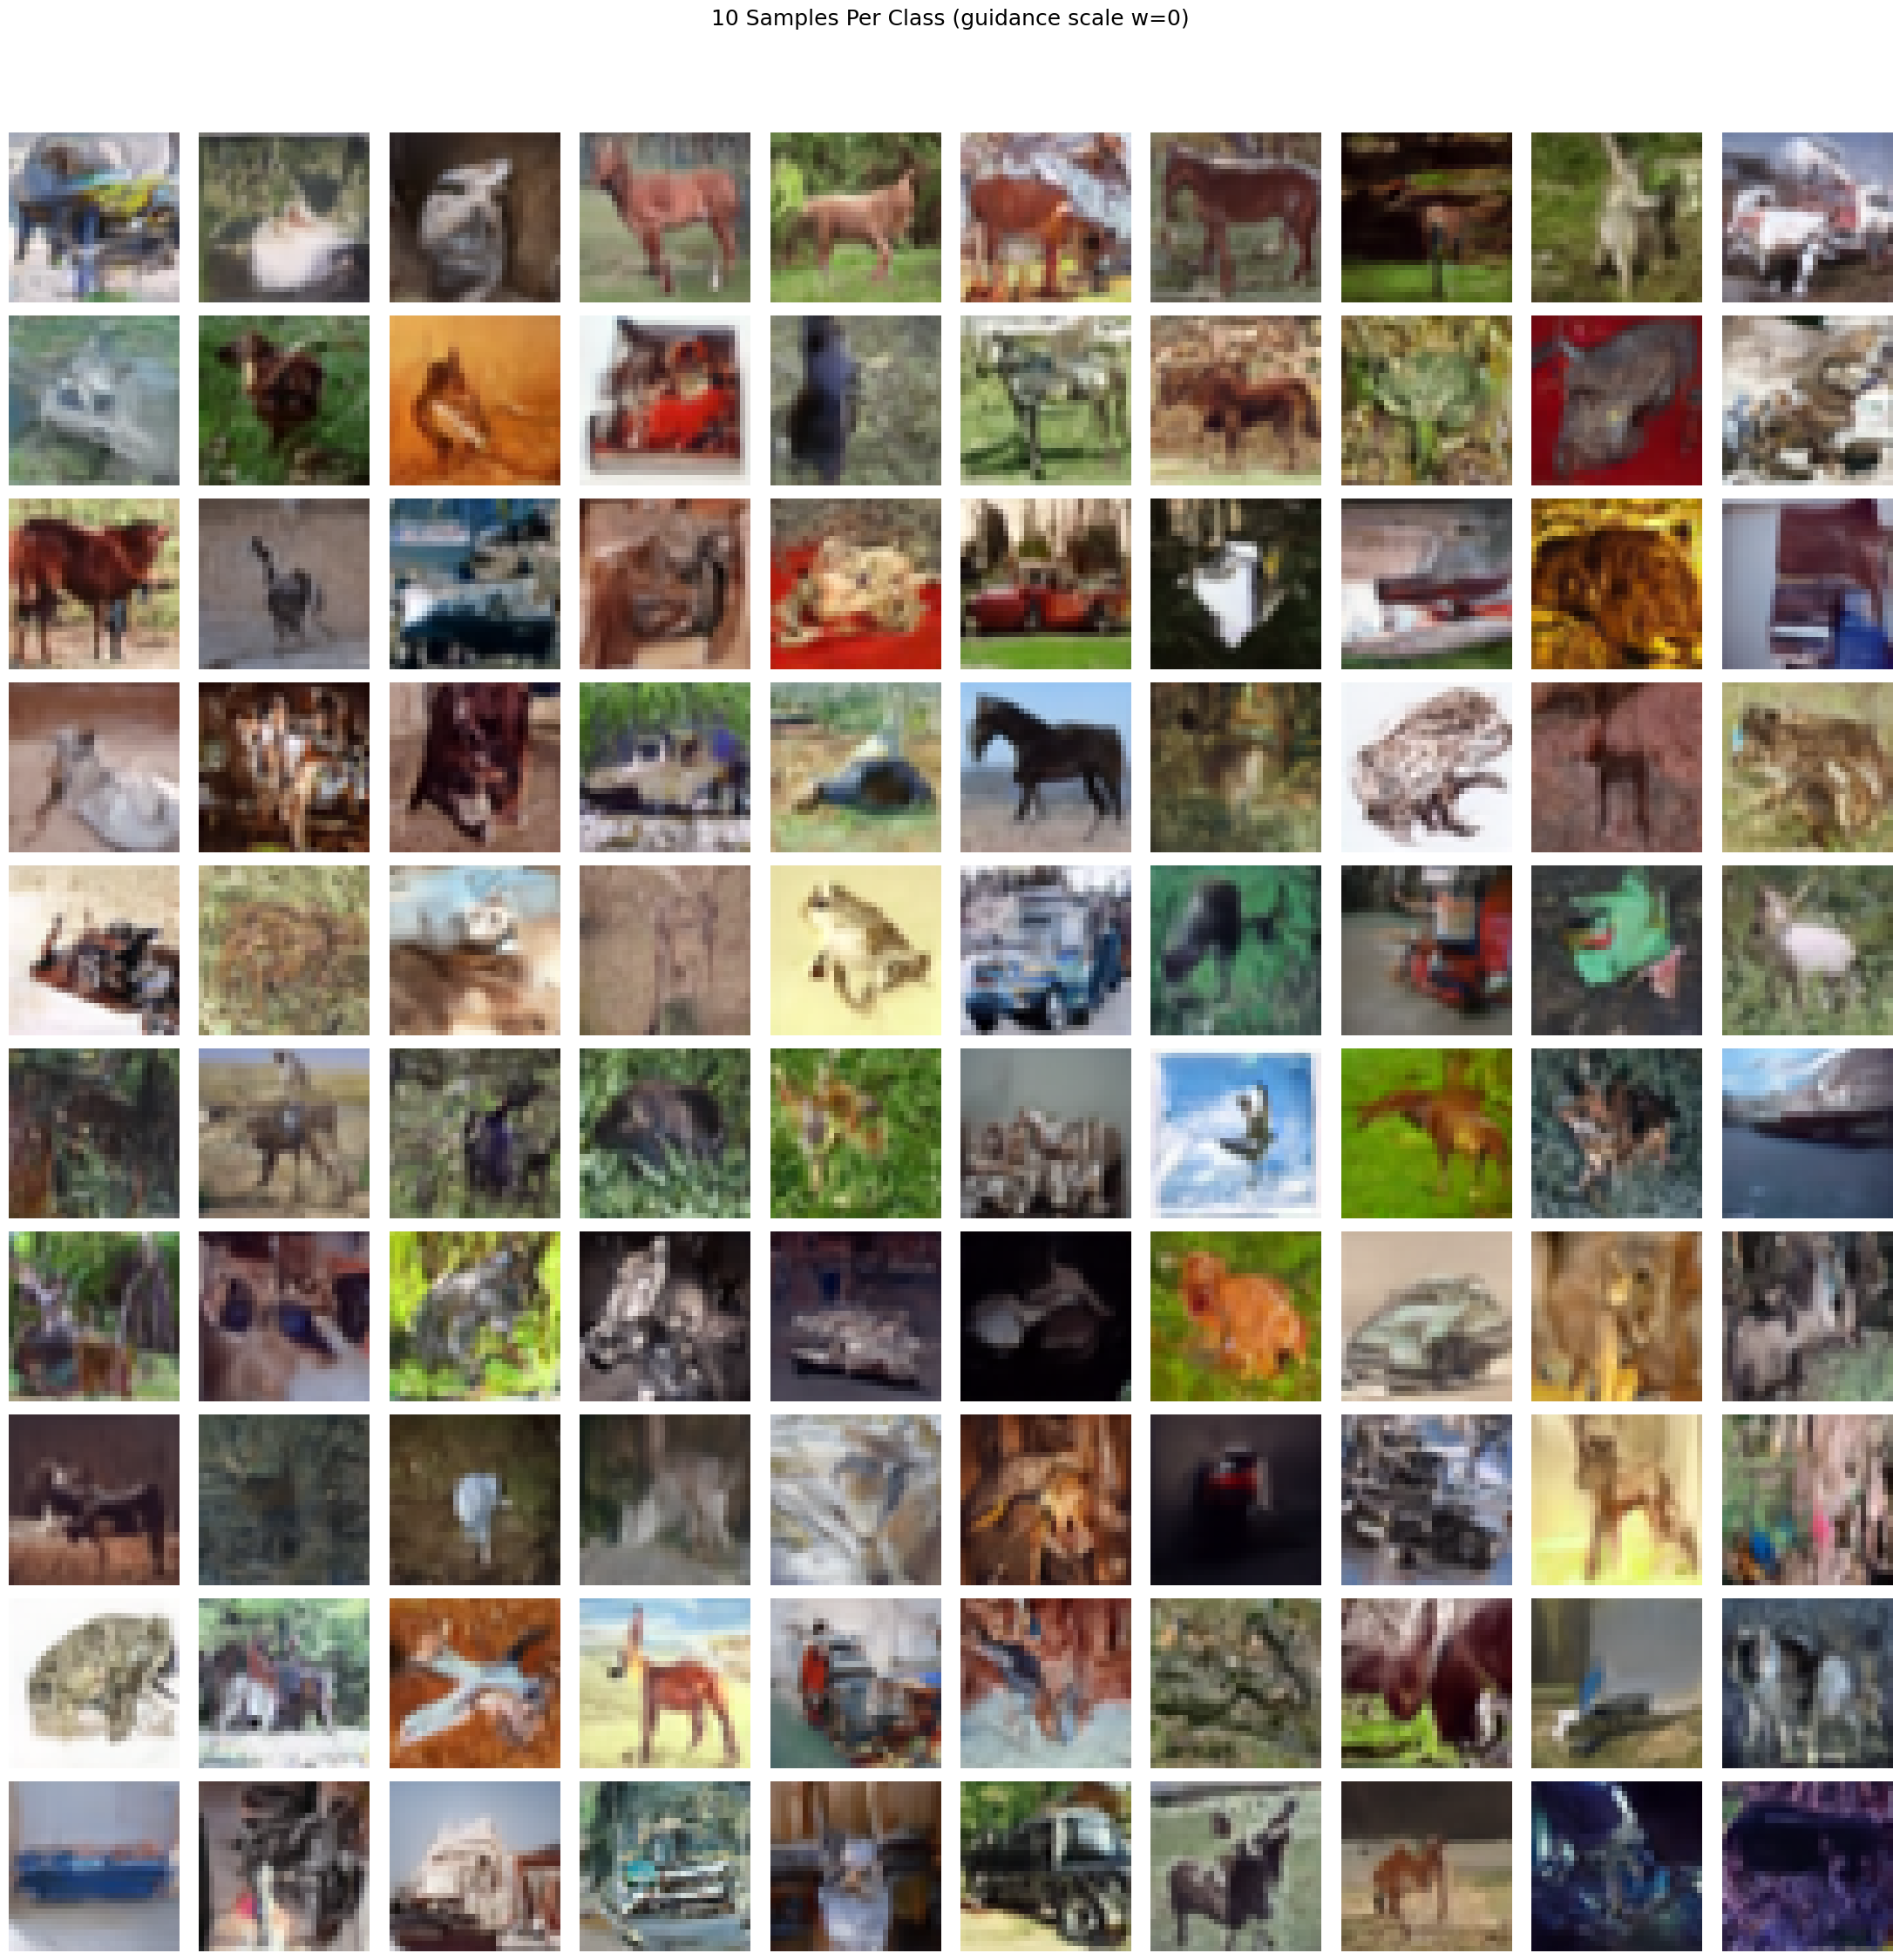

Generating: 100%|██████████| 50/50 [00:01<00:00, 39.61it/s]


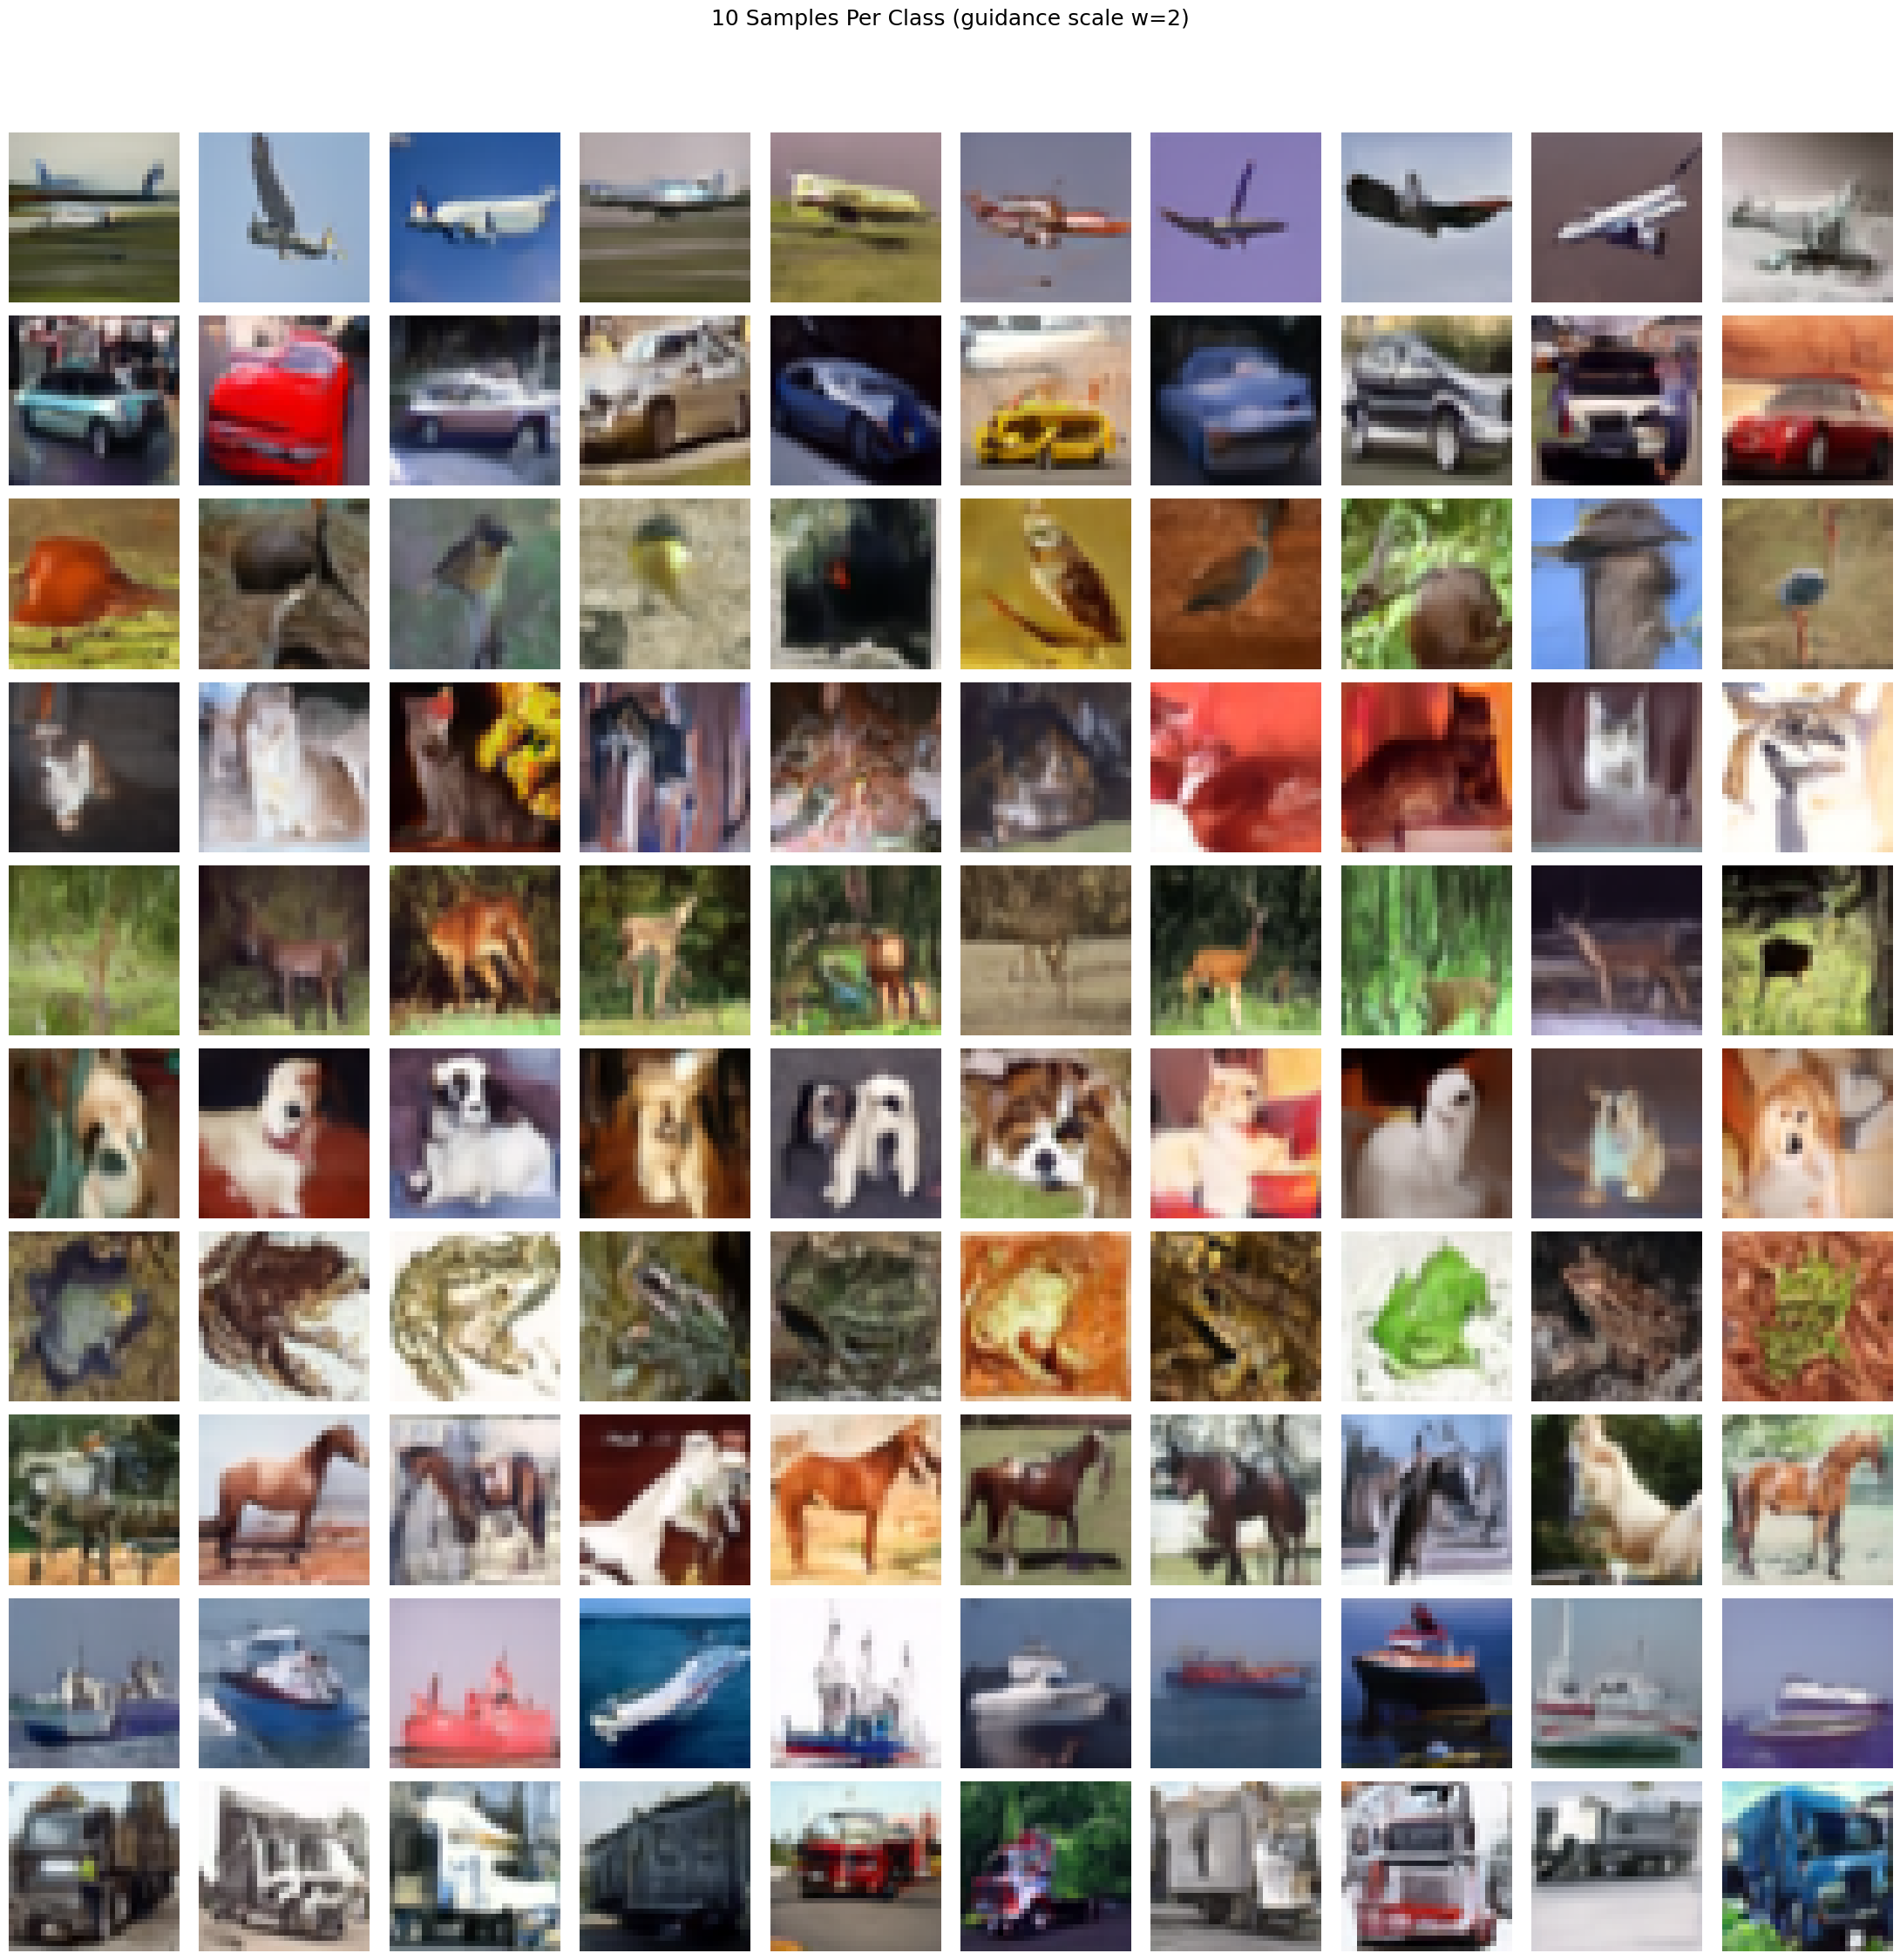

Generating: 100%|██████████| 50/50 [00:01<00:00, 39.16it/s]


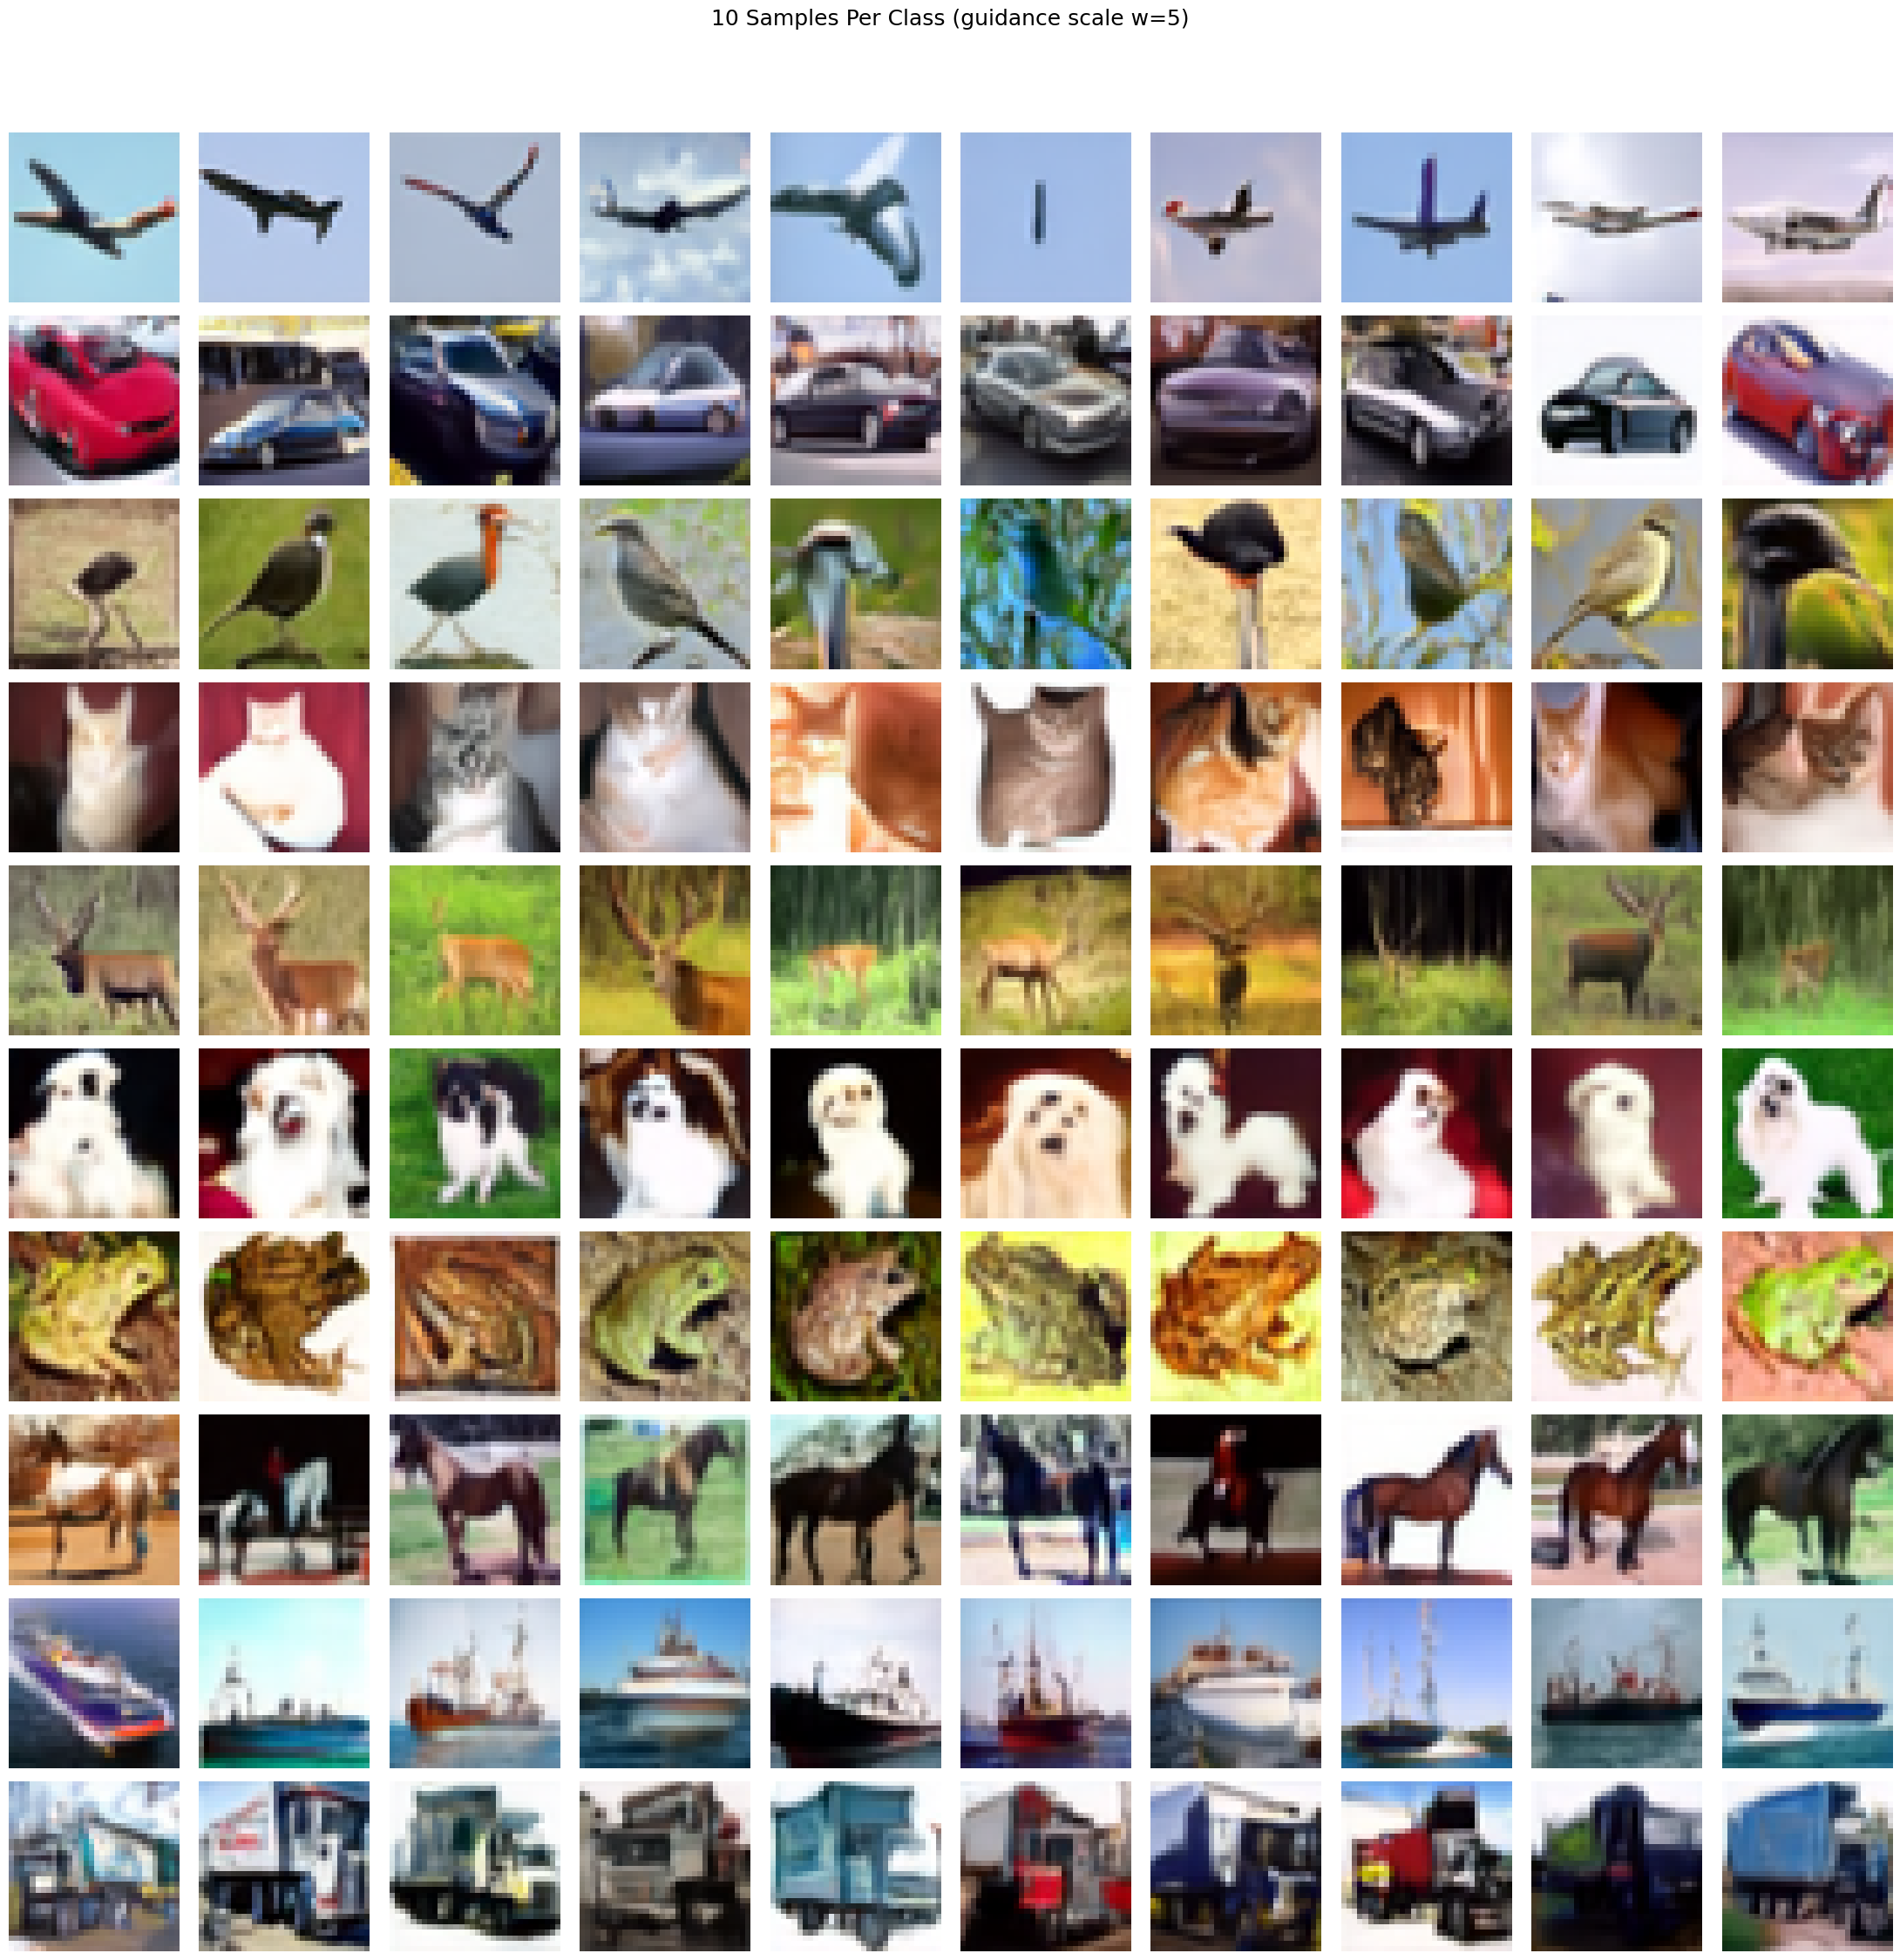

Generating: 100%|██████████| 50/50 [00:01<00:00, 40.27it/s]


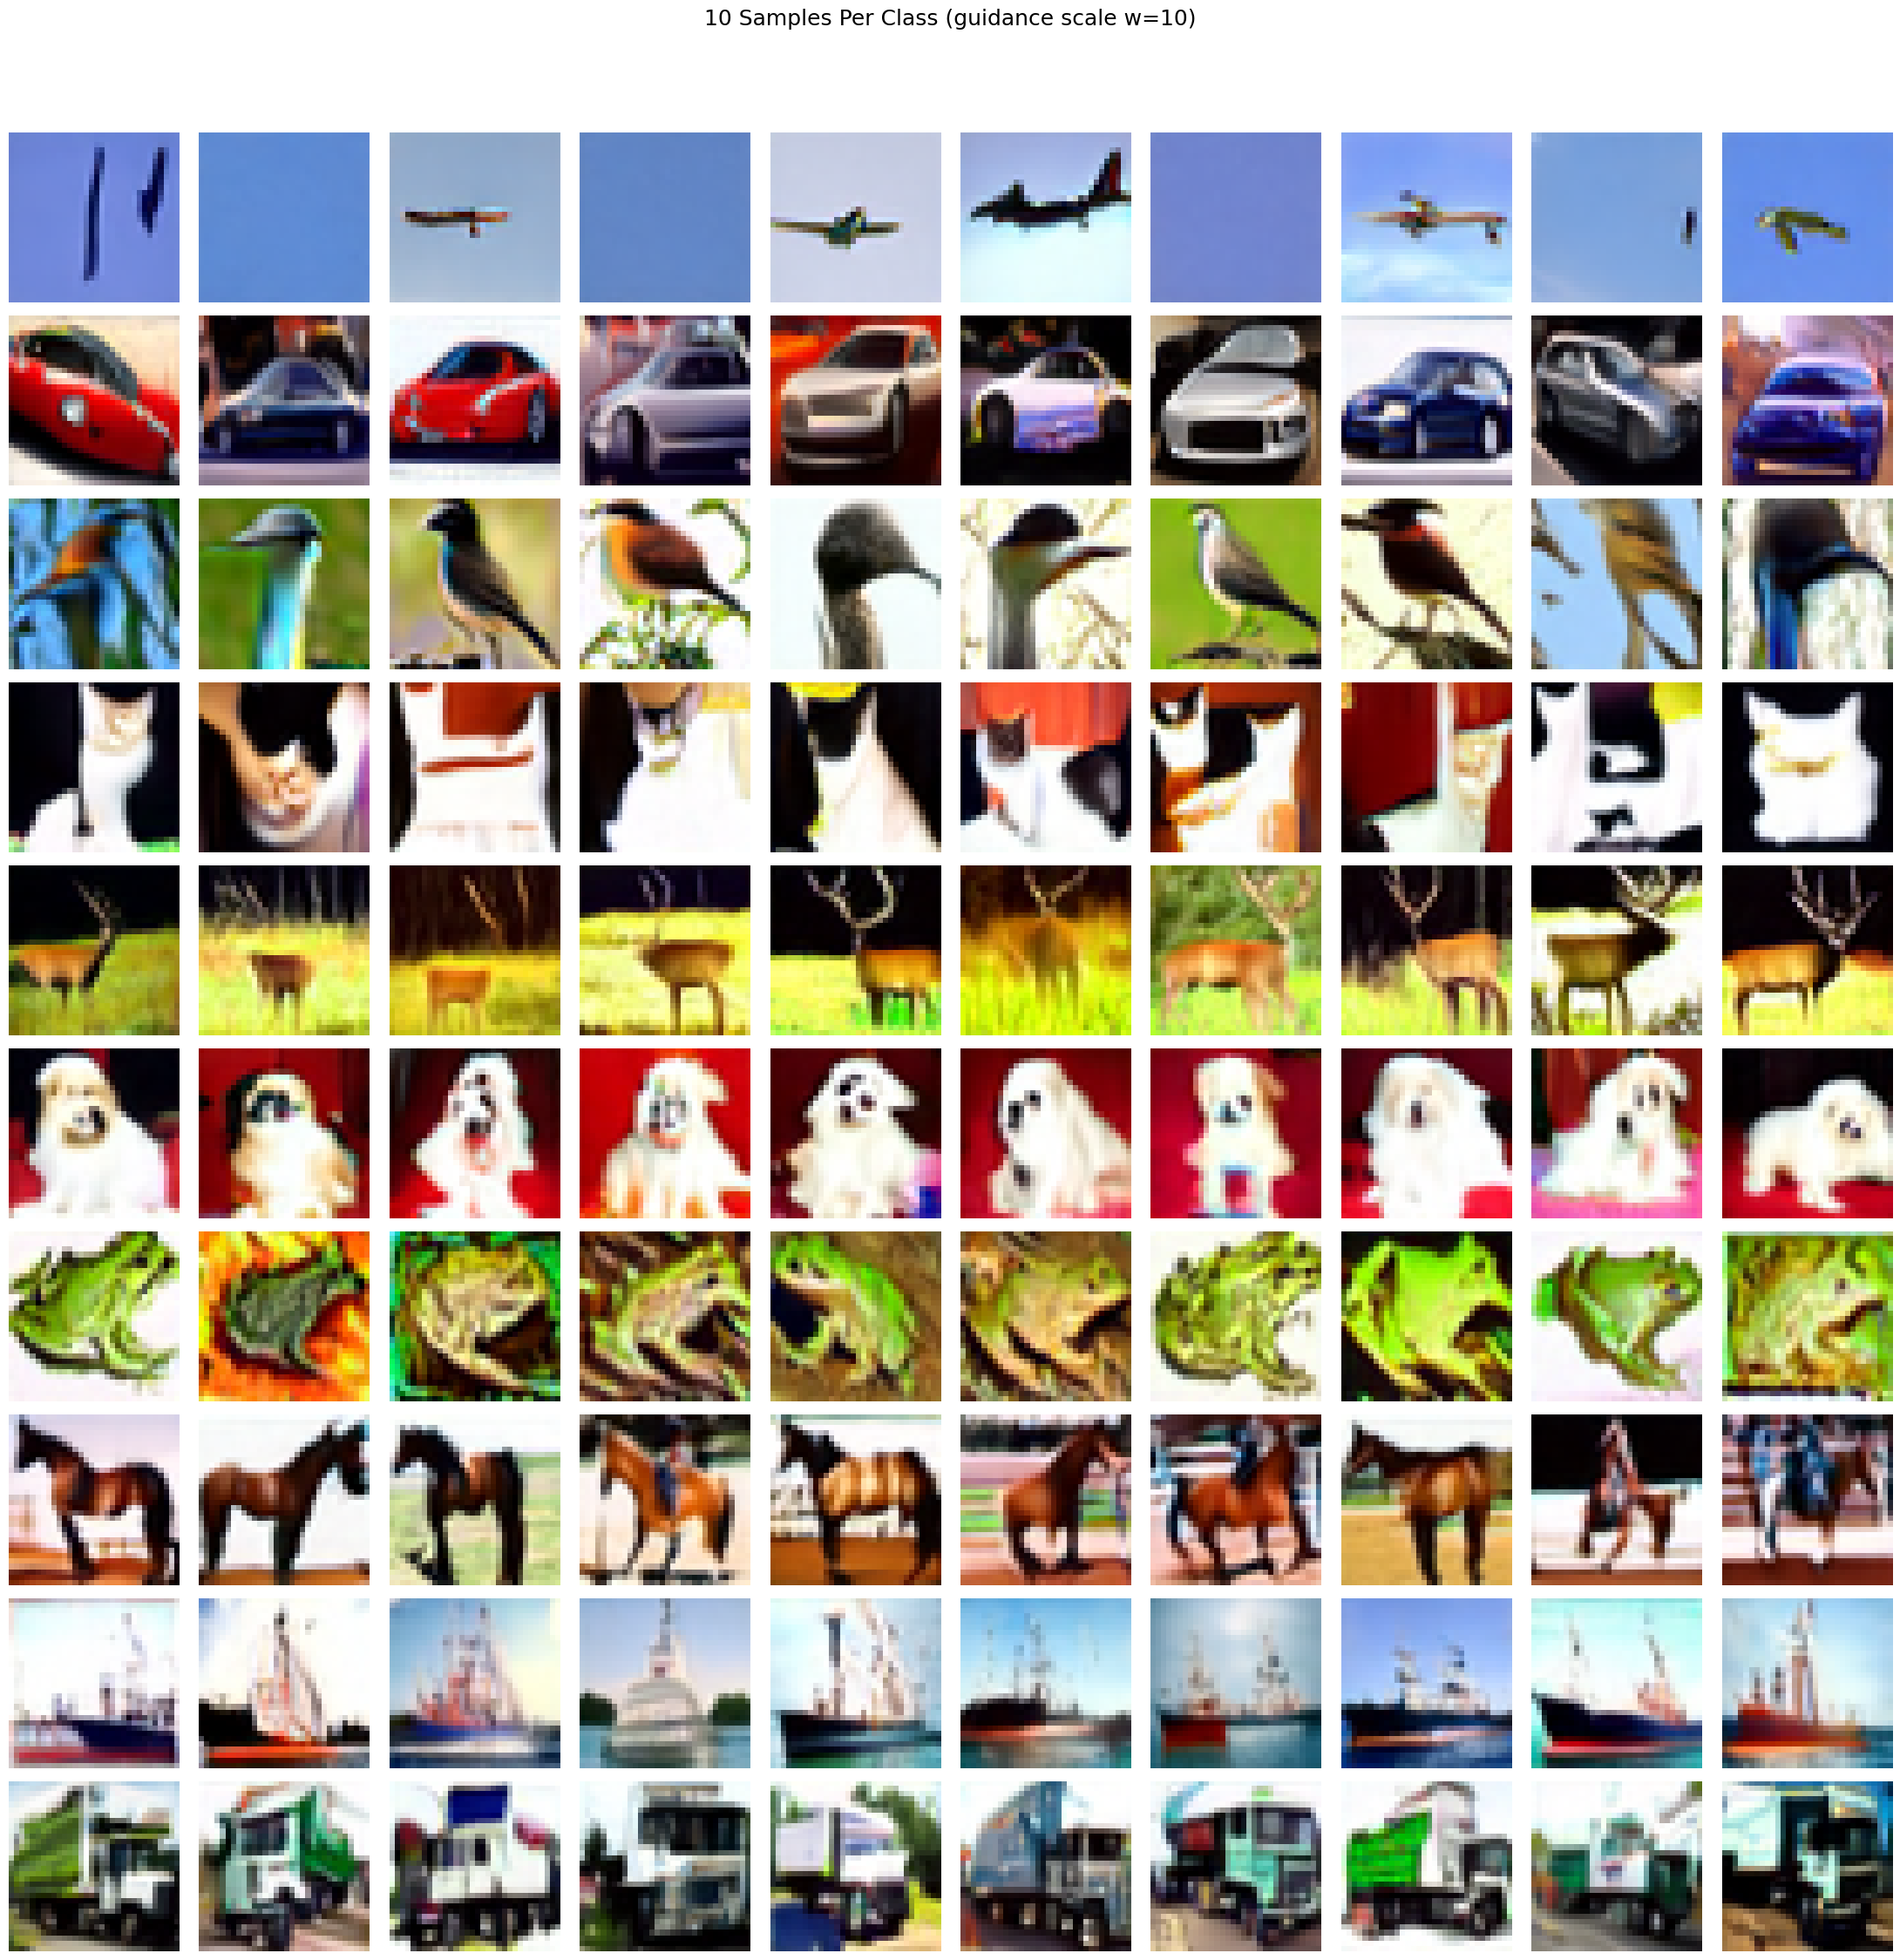

In [15]:
# Generate multiple samples per class for several guidance scales
num_samples_per_class = 10
guidance_scales = [0, 2, 5, 10]

for guidance_scale in guidance_scales:
    fig, axes = plt.subplots(10, num_samples_per_class, figsize=(2.2 * num_samples_per_class, 2.2 * 10))
    plt.suptitle(f'10 Samples Per Class (guidance scale w={guidance_scale})', fontsize=18, y=1.02)
    
    for class_idx, class_name in enumerate(CIFAR10_CLASSES):
        prompt = EXPERIMENT_2_CONFIG["prompt_template"].format(class_name=class_name)
        
        # Generate images for this class and guidance scale
        images = generate_images(
            prompt,
            guidance_scale=guidance_scale,
            num_images=num_samples_per_class,
            show_progress=True
        )
        
        for sample_idx in range(num_samples_per_class):
            ax = axes[class_idx, sample_idx]
            ax.imshow(images[sample_idx].permute(1, 2, 0).cpu().numpy())
            if sample_idx == 0:
                ax.set_ylabel(class_name, fontsize=12, rotation=0, ha='right', va='center')
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

## Summary

This notebook explored the trained CIFAR-10 diffusion model:

**Observations:**
- Guidance scale controls text prompt adherence
- Low w (0-1): Diverse but may not match prompt well
- Medium w (2-5): Good balance of quality and diversity
- High w (10+): Strong prompt adherence but may reduce diversity

**Next steps:**
1. Run `generate_images.ipynb` to bulk generate for evaluation
2. Run `metrics1_evaluate_cifar10.ipynb` to compute metrics